In [123]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from pathlib import Path, PureWindowsPath
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.min_rows', 10)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', None) #afficher texte entier dans dataframe

In [167]:
# corpus["message"].duplicated()
corpus_doublons = corpus[corpus.duplicated(["message"], keep=False)]
corpus_doublons.sort_values("message").reset_index(drop=True)

,id,message,message_preprocessed,category,length,category_bin
0,6944,* ![Maxime Georgel](https://secure.gravatar.com/avatar/4ec319bbecc7ef66dede7a14b93b7a33?s=80&d=mm&r=g),maxime georgelhttpssecuregravatarcomavatarecbbeccefdedeabbasdmmrg,baptism,112,0
1,5476,* ![Maxime Georgel](https://secure.gravatar.com/avatar/4ec319bbecc7ef66dede7a14b93b7a33?s=80&d=mm&r=g),maxime georgelhttpssecuregravatarcomavatarecbbeccefdedeabbasdmmrg,baptism,112,0
2,5387,* ![Maxime Georgel](https://secure.gravatar.com/avatar/4ec319bbecc7ef66dede7a14b93b7a33?s=80&d=mm&r=g),maxime georgelhttpssecuregravatarcomavatarecbbeccefdedeabbasdmmrg,baptism,112,0
3,6946,* ![Maxime Georgel](https://secure.gravatar.com/avatar/4ec319bbecc7ef66dede7a14b93b7a33?s=80&d=mm&r=g),maxime georgelhttpssecuregravatarcomavatarecbbeccefdedeabbasdmmrg,baptism,112,0
4,5478,* ![Maxime Georgel](https://secure.gravatar.com/avatar/4ec319bbecc7ef66dede7a14b93b7a33?s=80&d=mm&r=g),maxime georgelhttpssecuregravatarcomavatarecbbeccefdedeabbasdmmrg,baptism,112,0
...,...,...,...,...,...,...
4216,7059,"« Toutes les extrémités de la terre se souviendront de l’Éternel et se\ntourneront vers lui ; Toutes les familles des nations se prosterneront devant\nsa face. Car le règne est à l’Éternel, il domine sur les nations » (Psaume 22\n:28,29).",« toutes extrémité terre souviendront éternel tourneront ver toutes famille nation prosterneront devant face car règne éternel domine nation » psaume,baptism,235,0
4217,6239,"« Toutes les nations que tu as faites viendront se prosterner devant ta face,\nSeigneur, et rendre gloire à ton Nom. » (Psaume 86 :9).",« toutes nation faites viendront prosterner devant face seigneur rendre gloire nom » psaume,baptism,133,0
4218,7060,"« Toutes les nations que tu as faites viendront se prosterner devant ta face,\nSeigneur, et rendre gloire à ton Nom. » (Psaume 86 :9).",« toutes nation faites viendront prosterner devant face seigneur rendre gloire nom » psaume,baptism,133,0
4219,5200,"Étonnamment, le pédobaptisme ne consiste pas simplement à baptiser les\nenfants. Les catholiques pensent que tous les enfants peuvent être baptisés\ncar ils pensent qu’appliquer de l’eau consacrée sur le corps d’un enfant lui\nconfère une certaine grâce. Nous, les réformés, ne croyons pas que l’eau est\nmagique. Nous ne baptisons pas tous les enfants. Nous baptisons les enfants\n_de ceux qui professent la foi et sont membres réguliers de l’Église_ car nous\ncroyons que Dieu a établi un lien particulier entre les croyants et leurs\nenfants qui leur donne droit au baptême. Par ailleurs, les réformés baptisent\naussi des adultes. Et les baptistes baptisent aussi des enfants professants.\nAinsi, le débat n’est pas tant enfant vs. adulte que sur la nature de la\nfamille, sur la façon de considérer nos enfants et leur place dans l’Église.",étonnamment pédobaptisme consiste simplement baptiser enfant catholique pensent tous enfant peuvent être baptisé car pensent appliquer eau consacrée corps enfant confère certaine grâce réformé croyons eau magique baptisons tous enfant baptisons enfant ceux professent foi membre régulier église car croyons dieu a établi lien particulier entre croyant leurs enfant donne droit baptême ailleurs réformé baptisent aussi adulte baptiste baptisent aussi enfant professant ainsi débat tant enfant vs adulte nature famille façon considérer enfant place église,baptism,834,0


In [168]:
#preprocessing qui aurait du etre fait avant :
#enlever les retours a la ligne
corpus.replace("\\n", " ", regex=True, inplace=True)

#supprimer les doublons
print("corpus.shape =", corpus.shape)
corpus.drop_duplicates("message", inplace=True)
print("corpus.shape =", corpus.shape)

corpus.shape = (8228, 6)
corpus.shape = (4649, 6)


In [162]:
path = PureWindowsPath(os.getcwd() + "\\data\\input\\data.parquet")
path = path.as_posix()
corpus = pd.read_parquet(path) #engine="fastparquet"
corpus["category_bin"] = np.select([corpus["category"] == "philosophy"], [1], default=0)
corpus = corpus.sample(frac=1).reset_index(drop=True)
# corpus["category_bin"] = (corpus["category_bin"] == "philosophy")
corpus

,id,message,message_preprocessed,category,length,category_bin
0,2943,**La nature humaine s’est-elle unie au Logos de façon accidentelle ? Non.**,nature humaine est-elle unie logo façon accidentelle non,philosophy,75,1
1,3938,"La puissance peut faire le bien comme le mal. Or la béatitude est un bien\nparfait, et ne peut pas coller avec cette neutralité morale que l’on trouve\ndans le concept de puissance. Donc la béatitude n’est pas dans la puissance.",puissance peut faire bien comme mal or béatitude bien parfait peut coller cette neutralité morale trouve concept puissance donc béatitude puissance,philosophy,226,1
2,2472,"A l’inverse, celui qui enferme la théologie dans un bocal et se retire dans sa\npetite sphère chrétienne ne reconnaît pas la sagesse de Dieu, car il ne\ncherche pas à soummettre la création à Dieu, mais au contraire la fuit, comme\nsi le monde fonctionnait selon un certain plan, une certaine « sagesse » et le\nchrétien une « sagesse différente ». C’est là l’erreur des fondamentalistes.",a inverse celui enferme théologie bocal retire petit sphère chrétien reconnaît sagesse dieu car cherche soummettre création dieu contraire fuit comme si monde fonctionnait selon certain plan certaine « sagesse » chrétien « sagesse différente » là erreur fondamentaliste,philosophy,384,1
3,2705,"11. VAN TIL,&nbsp ; _Introduction to Systematic Theology_ , 2e éd., p.327–33.[↩]",van tilnbsp introduction to systematic theology e éd p–↩,philosophy,82,1
4,5953,### Une continuité de pratique : ce que je veux dire,continuité pratique veux dire,baptism,52,0
...,...,...,...,...,...,...
8223,905,#### Excursus : qu’est-ce que cela nous dit pour les victimes de viols ?,excursus est-ce cela dit victime viol,philosophy,72,1
8224,5683,"La troisième clause de l’alliance est celle de « connaître l’Eternel ». Dans\nle livre de Jérémie, cela signifie obéir à sa loi (4 :22, 5 :4-5, 9 :7,23, 22\n:15,16). Alors que du plus petit jusqu’au plus grand, tous étaient âpre au\ngain (6 :13), il est promis maintenant que du plus petit au plus grand, tous\nconnaîtront l’Eternel. Jérémie annonce donc un jour où la situation sera\ninversée, où il y aura une repentance et où le peuple sera ce qu’il aurait dû\nêtre : un peuple obéissant, du plus petit au plus grand.",troisième clause alliance celle « connaître eternel » livre jérémie cela signifie obéir loi - alors plus petit plus grand tous âpre gain promis maintenant plus petit plus grand tous connaîtront eternel jérémie annonce donc jour où situation inversée où repentance où peuple dû être peuple obéissant plus petit plus grand,baptism,514,0
8225,789,"> Jésus a dit (Mt 26.53) : « Ne puis-je pas prier mon Père, qui me fournirait\n> aussitôt plus de douze légions d’anges ? » Et ni lui-même ne pria, ni son\n> Père ne lui envoya d’anges pour résister aux juifs. Donc Dieu peut faire ce\n> qu’il ne fait pas.",jésus a dit mt « puis-je prier père fournirait aussitôt plus douze légion ange » ni lui-même pria ni père envoya ange résister juif donc dieu peut faire fait,philosophy,252,1
8226,3743,"Christ n’avait pas à craindre de mal ou de châtiment de la part de son Père.\nMais il reste le respect devant l’infinie grandeur du Dieu Souverain, et selon\nce sens, Christ avait le don de crainte, plus que tout autre homme.",christ craindre mal châtiment part père reste respect devant infinie grandeur dieu souverain selon sens christ don crainte plus tout autre homme,philosophy,223,1


In [169]:
zeros_subset = corpus.loc[corpus["category_bin"] == 0, :]
ones_subset = corpus.loc[corpus["category_bin"] == 1, :]
number_of_minority_class = len(zeros_subset)
sampled_ones = ones_subset.sample(number_of_minority_class)
print(sampled_ones.shape)
corpus = pd.concat([sampled_ones, zeros_subset], ignore_index=True)
corpus = corpus.sample(frac=1).reset_index(drop=True)
corpus.index = list(range(len(corpus)))
corpus["id"] = corpus.index	#creation de l'id seulement apres equilibrage des classes et melange aleatoire
print(corpus["category_bin"].value_counts())

(1825, 6)
1    1825
0    1825
Name: category_bin, dtype: int64


In [129]:
corpus

,id,message,message_preprocessed,category,length,category_bin
0,0,"Le Damascène place cette distinction dans le type de volonté et non de\ndécision, et prévient cette confusion : Il n’y a pas de secrets dans la\nvolonté de Dieu, ni de clauses secrètes. Il y a simplement une volonté\ngénérale et des volontés « circonstancielles ».",damascène place cette distinction type volonté non décision prévient cette confusion a secret volonté dieu ni clause secrète a simplement volonté générale volonté « circonstancielle »,philosophy,261,1
1,1,"Maxime est étudiant en médecine à Lille. Fondateur du blog Parlafoi.fr, il se\npassionne pour la théologie systématique, l'histoire du dogme et la\nphilosophie réaliste. Vous entendrez souvent dans sa bouche ""Thomas d'Aquin"",\n""Jean Calvin"" et ""Vive la scolastique"". Il affirme être marié à la meilleure\népouse du monde. Ils vivent ensemble sur Lille avec leurs deux enfants et sont\nmoniteurs de la méthode Billings.",maxime étudiant médecine lille fondateur blog parlafoifr passionne théologie systématique histoire dogme philosophie réaliste entendrez souvent bouche thomas aquin jean calvin vive scolastique affirme être marié meilleur épouse monde vivent ensemble lille leurs deux enfant moniteur méthode billings,philosophy,413,1
2,2,"[3]E. Lohse, Colossians and Philemon (coll. Hermeneia), Minneapolis, Fortress\nPress, 1972, p. 103 ; cité par D. Cobb.",e lohse colossians and philemon coll hermeneia minneapolis fortress press p cité cobb,baptism,117,0
3,3,"L’existence de Dieu dans les choses est une doctrine qui a deux particularités\n: d’une c’est la plus agressées et la plus rongée de toutes les doctrines\nchrétiennes. Les athées prétendent qu’il n’y a pas de Dieu dans la matière.\nLes déistes disent qu’il y a un Dieu et qu’il n’est pas dans la matière. Les\nmusulmans ne sont pas loin de penser la même chose. Il n’y a que des chrétiens\npour affirmer sans complexe que Dieu non seulement existe, mais qu’il existe\nDANS les choses. Deuxième particularité : elle est très peu défendue, et peu\nde chrétiens cherchent à comprendre comment au juste l’articulation. Merci à\nThomas d’Aquin de s’être posé la question.",lexistence dieu chose doctrine a deux particularité plus agressé plus rongée toutes doctrine chrétien athée prétendent a dieu matière déiste disent a dieu matière musulman loin penser chose a chrétien affirmer sans complexe dieu non seulement existe existe chose deuxième particularité très peu défendue peu chrétien cherchent comprendre comment juste articulation merci thomas aquin être posé question,philosophy,658,1
4,4,"Le statut de l’enfant de parents chrétiens ne peut pas être subordonné à\nl’administration ou non d’un signe. \nDans les faits, les enfants de parents pedo ou credo baptistes sont éduqués de\nla même manière, c’est-à-dire dans la crainte de l’Éternel LEUR Dieu. Comme\ntout autre, ils ont besoin de la croix. Si on croit à l’élection, l’une ou\nl’autre des positions n’aura aucune influence sur le choix déjà fait par Dieu\nde toute éternité et de sa grâce qu’il déverse sur les enfants baptisés ou\nnon… \nSauf à être sacramentaliste, les nourrissons baptisés ne partent pas avec une\nlongueur d’avance sur les autres et ne sont pas plus bénis… \nAyons la sagesse de penser qu’on ne peut pas clore un débat vieux de 500 ans\n(avec de grands théologiens de chaque bord), et comme disait le réformateur :\nil y a des doctrines de moindre importance…",statut enfant parent chrétien peut être subordonné administration non signe fait enfant parent pedo credo baptiste éduqués manière est-à-dire crainte éternel dieu comme tout autre besoin croix si croit élection autre position aucune influence choix déjà fait dieu toute éternité grâce déverse enfant baptisé non… sauf être sacramentaliste nourrisson baptisé partent longueur avance autres plus bénis… sagesse penser peut clore débat vieux an grand théologien chaque bord comme disait réformateur a doctrine moindre importance…,baptism,839,0
...,

In [170]:
X = corpus["message_preprocessed"]
y = corpus["category"]
y = corpus["category_bin"]
indices = corpus["id"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.33, random_state=42)
# y_train.value_counts()
# print(indices_train, indices_test)
# indices_test

In [171]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [172]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_score 

# Cross validation
#Methode version automatisee facile grace a la fonction RepeatedStratifiedKFold de sklearn
#Selection de modeles avec la k cross validation pour determiner le meilleur
#Modeles utilisés dans les papiers :
# LogisticRegression, MultinomialNB (= naive bayes), SVM (SVD petit data), SGDClassifier (SVD grand data)
# DecisionTreeClassifier, RandomForestClassifier
# AdaBoostClassifier, MLPClassifier
pd.set_option("display.precision", 2)
scoring = ['accuracy', 'precision', 'recall', 'f1']
# scoring = ['accuracy']
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('AdaBoostClassifier', AdaBoostClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RandomForest', RandomForestClassifier()))
# models.append(('MLPClassifier', MLPClassifier(max_iter=500)))
models.append(('SGDClassifier', SGDClassifier()))
models.append(('SVM', SVC()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
 
# evaluate each model in turn
results = []
names = []
num_iter = 2
for name, model in models:
    sum_test_accuracy = 0
    sum_test_f1 = 0
    sum_test_recall = 0
    sum_test_precision = 0
    kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=num_iter, random_state=None)
    cv_results = cross_validate(model, X_train_tfidf, y_train, cv=kfold, scoring=scoring)
    for k, scores in cv_results.items():
        cv_results[k] = round(np.mean(scores), 4) #on fait la moyenne de chaque score (rappel, precision, etc.) pour les k experiences
    print((str(list(cv_results.items())[2:])+" ({0})").format(name)) #2: pour ignorer les info inutiles

[('test_accuracy', 0.947), ('test_precision', 0.9524), ('test_recall', 0.9397), ('test_f1', 0.9457)] (LR)
[('test_accuracy', 0.8879), ('test_precision', 0.849), ('test_recall', 0.9414), ('test_f1', 0.8919)] (AdaBoostClassifier)
[('test_accuracy', 0.928), ('test_precision', 0.9089), ('test_recall', 0.9497), ('test_f1', 0.9285)] (KNN)
[('test_accuracy', 0.9368), ('test_precision', 0.9294), ('test_recall', 0.9438), ('test_f1', 0.9363)] (RandomForest)
[('test_accuracy', 0.9497), ('test_precision', 0.9481), ('test_recall', 0.9501), ('test_f1', 0.9489)] (SGDClassifier)
[('test_accuracy', 0.9523), ('test_precision', 0.9533), ('test_recall', 0.9501), ('test_f1', 0.9515)] (SVM)
[('test_accuracy', 0.8863), ('test_precision', 0.8707), ('test_recall', 0.9039), ('test_f1', 0.8862)] (DecisionTreeClassifier)
[('test_accuracy', 0.9528), ('test_precision', 0.9553), ('test_recall', 0.9484), ('test_f1', 0.9516)] (SVM)


In [180]:
# Learning curves du modele selectionne : performances du modele en fonction de la taille du trainset
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_score 
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#Entrees
    #train_sizes (liste de float) : tailles du train en pourcentage 
    #cv_param : parametres de type kfold pour la cross validation
def get_learning_curve(model, X_train, y_train, cv_param, scoring, train_sizes, n_jobs=-1):
    # print("train_sizes =", 100 * train_sizes * len(y_train))
    train_sizes, train_scores, cv_scores = learning_curve(model, X_train, y_train, cv=cv_param, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    # learning_curve(AdaBoostClassifier(), X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    cv_scores_mean = np.mean(cv_scores, axis=1)
    cv_scores_std = np.std(cv_scores, axis=1)
    model_name = str(model)
    plt.figure()
    train_plot_label = scoring.capitalize() + " sur le trainset"
    cv_plot_label = scoring.capitalize() + " sur le cvset"
    title = scoring.capitalize() + " sur le trainset et sur le cvset en fonction de la taille du trainset pour " + model_name
    plt.plot(train_sizes, train_scores_mean, label=train_plot_label, color="b")
    plt.plot(train_sizes, cv_scores_mean, label=cv_plot_label, color="r")
    plt.title(title)
    plt.xlabel("Taille du trainset", fontsize=12)
    plt.ylabel(scoring.capitalize(), fontsize=12)
    plt.legend(loc="upper right")
    plt.show()

k = 10
# kfold = StratifiedKFold(n_splits=k, random_state=None, shuffle=True) #n_splits = k de la k-fold cv, le nombre de fold
kfold = RepeatedStratifiedKFold(n_splits=k, n_repeats=2, random_state=None)
scoring = 'accuracy'
cv_param = kfold 
num_experiences = 10
train_sizes = np.linspace(0.1, 1.0, num_experiences)
# train_sizes = np.linspace(0.001, 1.0, num_experiences)
n_jobs = -1

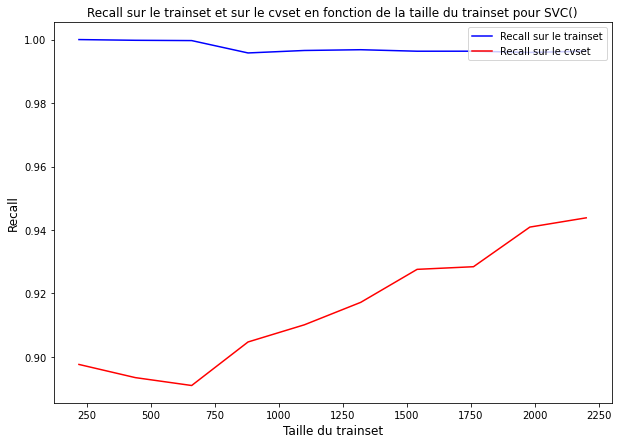

In [181]:
model = SVC() 
get_learning_curve(model, X_train_tfidf, y_train, cv_param, "recall", train_sizes, n_jobs)

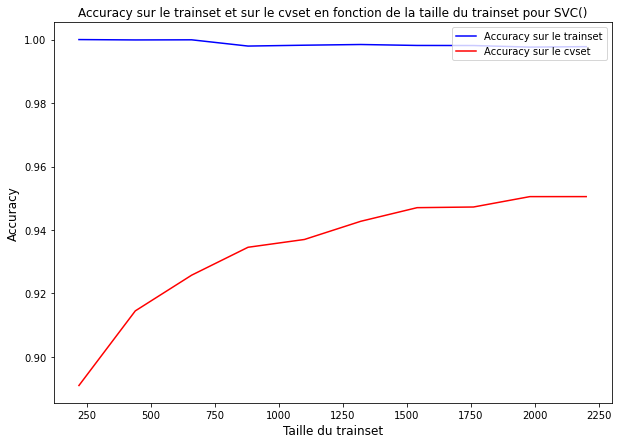

In [182]:
get_learning_curve(model, X_train_tfidf, y_train, cv_param, "accuracy", train_sizes, n_jobs)

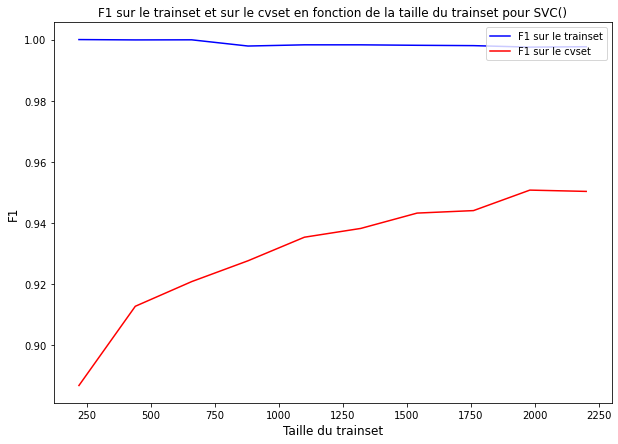

In [183]:
get_learning_curve(model, X_train_tfidf, y_train, cv_param, "f1", train_sizes, n_jobs)

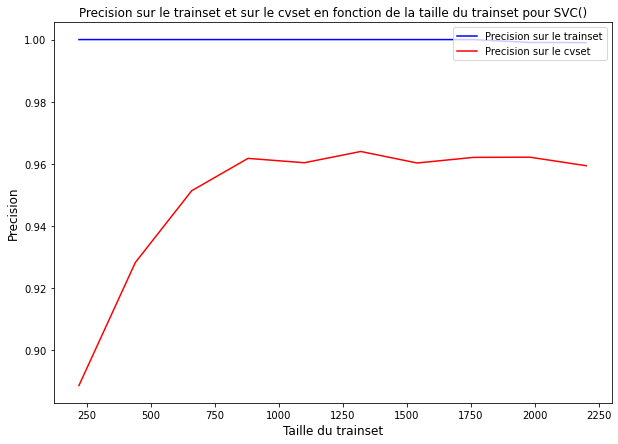

In [184]:
get_learning_curve(model, X_train_tfidf, y_train, cv_param, "precision", train_sizes, n_jobs)

In [185]:
# entrainement du modele
# model = MultinomialNB()
model = SVC()
model.fit(X_train_tfidf, y_train)

SVC()

In [186]:
# test du modele
X_test_tfidf = tfidf_vectorizer.transform(X_test)
y_pred = model.predict(X_test_tfidf)
print(y_pred)
print(X_test.shape)
print(X_test_tfidf.shape)

[0 1 0 ... 0 1 0]
(1205,)
(1205, 9486)


C:\Users\eupho\AppData\Local\Temp/ipykernel_22248/2510564835.py:19: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_xticklabels([false_label, true_label], Fontsize=font_size + 3)
C:\Users\eupho\AppData\Local\Temp/ipykernel_22248/2510564835.py:20: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_yticklabels([false_label, true_label], Fontsize=font_size + 3)


Text(69.0, 0.5, 'Catégories réelles')

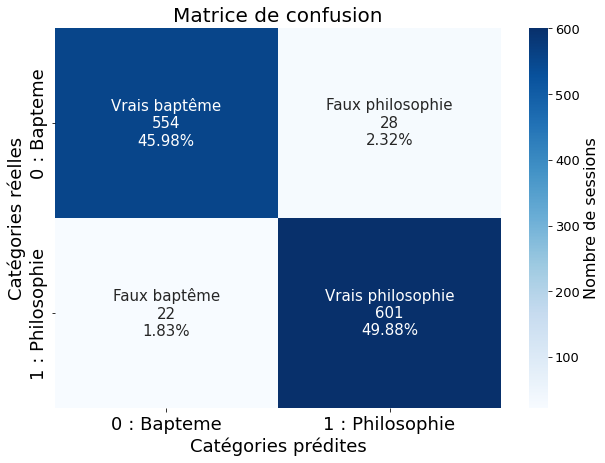

In [187]:
# Matrice de confusion
false_label = "0 : Bapteme"
true_label = "1 : Philosophie"
confusion_matrix_var = confusion_matrix(y_test, y_pred, labels=model.classes_)
group_names = ["Vrais baptême", "Faux philosophie", "Faux baptême", "Vrais philosophie"]
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix_var.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix_var.flatten()/np.sum(confusion_matrix_var)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
font_size = 15 #19
plt.rcParams["figure.figsize"] = (10, 7) #taille du graphique, taille du plot
ax = sb.heatmap(confusion_matrix_var, 
                annot=labels, fmt="", cmap='Blues',
                annot_kws={"size": font_size}, 
                cbar_kws={'label': 'Nombre de sessions'})
ax.set_xticklabels([false_label, true_label], Fontsize=font_size + 3)
ax.set_yticklabels([false_label, true_label], Fontsize=font_size + 3)
ax.figure.axes[-1].yaxis.label.set_size(font_size + 1)
ax.figure.axes[-1].tick_params(labelsize=font_size - 2) 
plt.title("Matrice de confusion", fontsize = font_size + 5)
# xlabel = 'Catégories prédites\n\n Exactitude (bien classés) = {:0.2f} % ; Inexactitude (mal classés) = {:0.2f} %\n Précision (bonnes prédictions de robots / qualité) = {:0.2f} %\n Rappel (nombre de robots détectés / quantité) = {:0.2f} %\n F1 (synthèse de précision + rappel) = {:0.2f} %'.format(accuracy, (100 - accuracy), precision, recall, f1_score)
plt.xlabel("Catégories prédites", fontsize=font_size + 3)
plt.ylabel("Catégories réelles", fontsize=font_size + 3)

In [188]:
# Metriques
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       582
           1       0.96      0.96      0.96       623

    accuracy                           0.96      1205
   macro avg       0.96      0.96      0.96      1205
weighted avg       0.96      0.96      0.96      1205



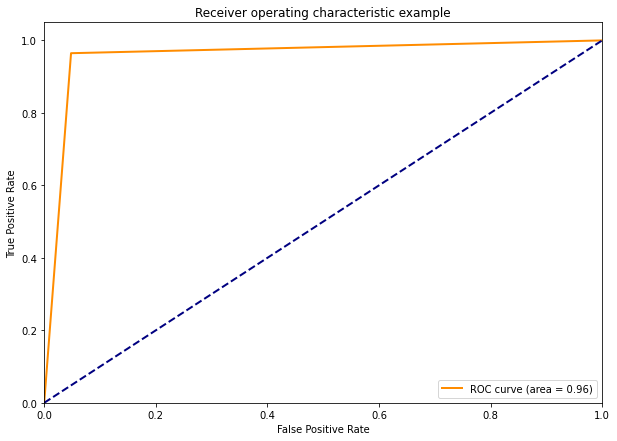

In [189]:
# Courbe ROC et AUC
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [198]:
# On affiche les documents a propos desquels le modele s'est trompe
corpus_test = pd.DataFrame({"id":corpus.iloc[indices_test].id, "message": corpus.iloc[indices_test].message, "truth":y_test, "pred":y_pred})
corpus_test_errors = corpus_test.query("truth != pred")
print(corpus_test.shape)
print(corpus_test_errors.shape)
# corpus_test_errors = corpus_test_errors[["truth", "pred", "message_preprocessed"]]
print(corpus_test_errors.columns)
corpus_test_errors = corpus_test_errors[["id", "truth", "pred", "message"]]
# corpus_test_errors

(1205, 4)
(50, 4)
Index(['id', 'message', 'truth', 'pred'], dtype='object')


In [202]:
with pd.option_context("display.max_rows", 1000):
    display(corpus.iloc[corpus_test_errors[corpus_test_errors["pred"] == 1].id]) #aux philosophie

,id,message,message_preprocessed,category,length,category_bin
1674,1674,"Tu veux une vraie réponse venant de Dieu ? Arrête les livres, les études et va vers Dieu en prière et Dieu t’ouvrira les yeux ! Comme Il l’a fait pour moi ! Et là, et seulement là, tu mettras ta foi dans des réponses émanant de Dieu directement et non via tes propres forces, moyens, intelligences et pensées.",veux vraie réponse venant dieu arrête livre étude va ver dieu prière dieu ouvrira yeux comme a fait là seulement là mettras foi réponse émanant dieu directement non via propre force moyen intelligence pensée,baptism,309,0
17,17,"4) Dieu n’oppose jamais dans sa Parole la connaissance et l’obéissance. Au contraire, il dit « mon peuple périt par manque de connaissance ».",dieu oppose jamais parole connaissance obéissance contraire dit « peuple périt manque connaissance »,baptism,141,0
1533,1533,"[2]F. Turretin, Institutio theologiae elencticae, Vol. 2, Genève, Samuel de Tournes, 1689, XII.XII.I, p. 286.",f turretin institutio theologiae elencticae vol genève samuel tourne xiixiii p,baptism,109,0
2821,2821,"En attendant, vous pouvez consulter nos articles sur les [Alliances](https://parlafoi.fr/category/alliances/) et ceux sur les [Sacrements](https://parlafoi.fr/category/theologie/sacrements/).",attendant pouvez consulter article allianceshttpsparlafoifrcategoryalliances ceux sacrementshttpsparlafoifrcategorytheologiesacrements,baptism,191,0
1309,1309,"=> « Incirconcis de cœur » ! Ça ne vous parles pas ? Cela montrent deux choses : – premièrement : Ils étaient circoncis mais pas de coeur. Cela veut dire qu’ils avaient un « esprit religieux », ils faisaient tout par tradition mais leurs cœurs n’étaient pas en Dieu. Alors cela déplu à Dieu. – deuxièmement : que Dieu n’a que faire des traditions et des religions, ce qu’Il attends de homme est un cœur entier, pur, qui aime Dieu et fasse Sa Volonté par L’Esprit-Saint !",« incirconcis cœur » ça parles cela montrent deux chose – premièrement circoncis coeur cela veut dire « esprit religieux » faisaient tout tradition leurs cœurs dieu alors cela déplu dieu – deuxièmement dieu a faire tradition religion attends homme cœur entier pur aime dieu fasse volonté esprit-saint,baptism,474,0
1602,1602,"On tourne en rond, puisque nous venons justement de montrer qu’Hébreux ne dit pas cela. On peut poursuivre la discussion sur ce point. J’aimerai bien voir ta réaction à cet article : <https://parlafoiblog.wordpress.com/2018/07/26/hebreux-les-alliances-et-les- avertissements/>",tourne rond puisque venons justement montrer hébreux dit cela peut poursuivre discussion point aimerai bien voir réaction cet article httpsparlafoiblogwordpresscomhebreux-les-alliances-et-les- avertissement,baptism,278,0
2181,2181,Je vous recommande donc vraiment de lire l’article sur la circoncision mentionné pour pouvoir comprendre celui-là.,recommande donc vraiment lire article circoncision mentionné pouvoir comprendre celui-là,baptism,114,0
3521,3521,"De plus, la Bible est claire (et là j’ai envie de crier Amen !). Elle l’est vraiment. Il faut être patient et étudier mais Dieu ne nous a pas donné un recueil de mystères. Il nous a donné sa Parole, dans un langage humain, logique, compréhensible et accessible. Elle a un sens objectif, oui. Et il peut être découvert !",plus bible claire là envie crier amen vraiment faut être patient étudier dieu a donné recueil mystère a donné parole langage humain logique compréhensible accessible a sens objectif oui peut être découvert,baptism,319,0
2716,2716,"Le débat autour de la transsubstantation ? Le plus ecclésiologique de tous : il ne s’agissait pas tant de savoir si le pain était la chair de Jésus que de **savoir si l’Église était médiatrice entre l’homme et Dieu** : si le prêtre a le pouvoir de changer le pain et le vin en corps et sang du Christ, alors la grâce de Dieu (qui est toute entière contenue dans le Christ) se retrouve à nouveau dans les mains de la prêtrise romaine.",débat autour transsubstanta

In [204]:
with pd.option_context("display.max_rows", 1000):
    display(corpus.iloc[corpus_test_errors[corpus_test_errors["pred"] == 0].id]) #faux bapteme

,id,message,message_preprocessed,category,length,category_bin
3100,3100,"Je saute l’article 10 car il apporte très peu de données nouvelles, et me concentre sur une question qui va probablement intéresser tous les hébraïsants et autres « Je parle à moitié hébreu dans mes prières, même si je ne sais pas lire l’alphabet en vrai ».",saute article car apporte très peu donnée nouvelle concentre question va probablement intéresser tous hébraïsant autres « parle moitié hébreu prière si sais lire alphabet vrai »,philosophy,257,1
149,149,[Maxime N. Georgel](http://www.parlafoi.local) sur 27 janvier 2020 à 21 h 20 min,maxime georgelhttpwwwparlafoilocal janvier heure min,philosophy,80,1
1261,1261,"« De ceux qui lui sont unis en acte par la foi » : les nouveaux convertis, dans cette vie.",« ceux uni acte foi » nouveau converti cette vie,philosophy,90,1
2121,2121,"6. Pour un recensement utile de ces débats, voir AYRES, Lewis, _Nicaea and its Legacy: An Approach to Fourth Century Trinitarian Theology_ (Oxford, England: Oxford University Press, 2004).[↩]",recensement utile débat voir ayres lewis nicaea and its legacy an approach to fourth century trinitarian theology oxford england oxford university press ↩,philosophy,193,1
439,439,"C’est le point de départ d’une querelle de métaphysiciens de très haut niveau dont je ne suis tout juste capable de comprendre les questions. Alors restons- en là: Malgré les critiques qu’essuie depuis 800 ans la doctrine de « l’analogie de l’être » ou _analogia entis_ , elle trouve encore aujourd’hui des défenseurs, ce qui semble signifier qu’elle n’est pas si boîteuse.",cest point départ querelle métaphysicien très haut niveau dont tout juste capable comprendre question alors restons- là malgré critique essuie depuis an doctrine « analogie être » analogia entis trouve encore hui défenseur semble signifier si boîteuse,philosophy,373,1
1361,1361,"> On ne doit rien faire dans le culte divin qui n’ait été institué par Dieu. > Aussi l’Apôtre lui-même, quand il va donner un enseignement sur le sacrifice > de l’Église, dit-il (1 Co 11, 23) : « J’ai reçu du Seigneur ce que je vous > ai transmis. » Or on ne trouve dans l’Écriture aucun enseignement en faveur > de l’adoration des images du Christ. **Réponse :** Les Apôtres, guidés par > l’impulsion intérieure de l’Esprit Saint, ont transmis aux Églises certaines > traditions qu’ils n’avaient pas laissées dans leurs écrits, mais dans la > pratique de l’Église, que les fidèles se transmettaient. C’est ainsi que S. > Paul dit aux Thessaloniciens (2 Th 2,14) : « Tenez ferme et attachez-vous > aux traditions que vous avez reçues de nous, de vive voix ou par lettre. » > Et parmi ces traditions il y a l’adoration des images du Christ. C’est > pourquoi on attribue à S. Luc une peinture du Christ qui se trouve à Rome.",doit rien faire culte divin institué dieu aussi apôtre lui-même quand va donner enseignement sacrifice église dit-il co « reçu seigneur transmis » or trouve écriture aucun enseignement faveur adoration image christ réponse apôtre guidés impulsion intérieure esprit saint transmis église certaines tradition laissées leurs écrit pratique église fidèle transmettaient ainsi paul dit thessaloniciens th « tenez ferme attachez-vous tradition reçu vive voix lettre » parmi tradition a adoration image christ pourquoi attribue luc peinture christ trouve rome,philosophy,922,1
1421,1421,"_Ou bien, selon S. Jérôme’. » C’est expressément qu’il dit : « Cette coupe », c’est-à-dire celle du peuple des Juifs qui ne peuvent avoir l’excuse de l’ignorance, s’ils me mettent à mort, car ils ont la Loi et les Prophètes qui me prophétisent chaque jour. »_",bien selon » expressément dit « cette coupe » est-à-dire celle peuple juif peuvent avoir excuse ignorance mettent mort car loi prophète prophétisent chaque jour »,philosophy,259,1
3437,3437,"Les païens n’adoraient pas leurs images comme des réalités. Turretin cite le témoignage de Celsus, Arnobius et même le témoignage adverse d’Augustin q

In [209]:
# on affiche les poids des mots tfidf
idf = tfidf_vectorizer.idf_
scores_tfidf = pd.DataFrame({"words":tfidf_vectorizer.get_feature_names(), "idf":idf})
scores_tfidf = scores_tfidf.sort_values("idf", ascending=False)
with pd.option_context("display.max_rows", 10000):
    display(scores_tfidf)

c:\Users\eupho\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,words,idf
0,aaaayaajpgpadqthechildofthecovenantorhowchristianparentsshouldtrainuptheirhouseholds,8.11
5200,marty,8.11
5216,mathsinfo,8.11
5214,mathieu,8.11
5209,massoud,8.11
5208,massivement,8.11
5207,massicotte,8.11
5206,masse,8.11
5205,masculin,8.11
5204,martèle,8.11


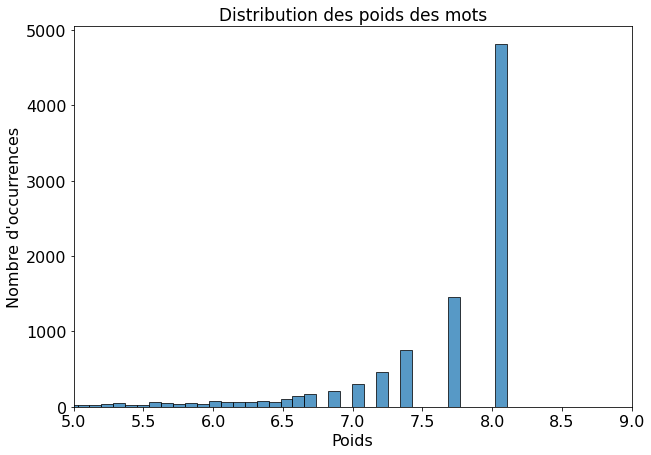

In [210]:
# Distribution des poids des mots (calcules avec sklearn)
path = PureWindowsPath(os.getcwd() + "\\data\\output\\words_weights_distribution.png")
path = path.as_posix()

sb.histplot(data=scores_tfidf, x="idf")
# plt.yscale('log')
plt.xlabel("Poids", size=16)
plt.ylabel("Nombre d'occurrences", size=16)
plt.title("Distribution des poids des mots", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
plt.xlim(5, 9)
plt.savefig(path)
plt.show()

In [211]:
# Calcul manuel des poids
print("X_train_tfidf.shape =", X_train_tfidf.shape)
words_weights = X_train_tfidf.sum(axis=0)
print("words_weights.shape =", words_weights.shape)
print(words_weights)
print(words_weights.shape)

X_train_tfidf.shape = (2445, 9486)
words_weights.shape = (1, 9486)
[[0.28464511 1.00185283 0.13954759 ... 0.13743326 0.06200042 0.13743326]]
(1, 9486)


In [212]:
words_weights = np.ravel(words_weights)
print(words_weights)
print(words_weights.shape)

[0.28464511 1.00185283 0.13954759 ... 0.13743326 0.06200042 0.13743326]
(9486,)


In [213]:
# words_weights[:10]
np.set_printoptions(suppress=True)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
np.unique(words_weights).shape
np.max(words_weights)
np.min(words_weights)

0.032307875483980605

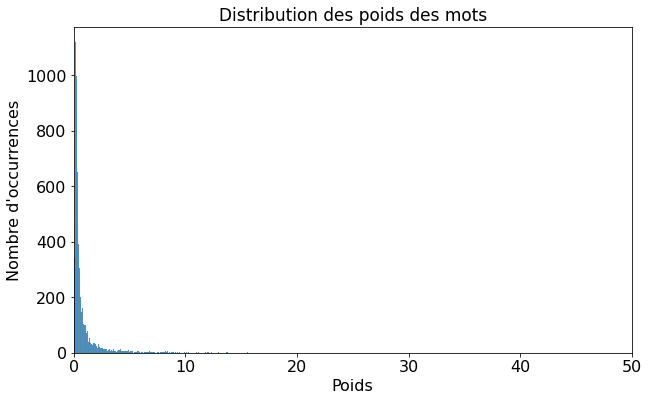

In [215]:
# Distribution des poids des mots (calcules avec a la main)
path = PureWindowsPath(os.getcwd() + "\\data\\output\\words_weights_distribution_manuel.png")
path = path.as_posix()

# sb.histplot(words_weights[:100000])
sb.histplot(words_weights)
# plt.yscale('log')
plt.xlabel("Poids", size=16)
plt.ylabel("Nombre d'occurrences", size=16)
plt.title("Distribution des poids des mots", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
plt.xlim(0, 4)
plt.savefig(path)
plt.show()